In [2]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import shapefile   
import geopandas as gpd
import geoplot as gplt
import contextily as cx

from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [27]:
# Directories and Variable initialization
dir_era5 = '/glade/work/mingge/ERA5/'
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
year_s = 1979
year_e = 2019

#### 1a) Map of daily P99 precipitation value by grid pt   ERA5 grided dataset 

In [35]:
# prec_p99_1979-2019.nc with ignor <0.1 mm/day
flnm_o = dir_o +  'prec_p99_' + str(year_s) + '-' + str(year_e) + '.nc'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        prec_p99 = ds.prec
else:
    for year in range(year_s, year_e+1, 1):
        print(year)
        for month in range(1,13,1):
            mon_s = str(month).zfill(2)
            flnm = dir_era5 + 'prec_' + str(year) + mon_s + '_daily.nc'
            #print(flnm)
            with  xr.open_dataset(flnm) as ds:
                prec = ds.cp + ds.lsp                  
                
            if year == year_s and month == 1:
                data_all = prec.copy()
            else:
                data_all = xr.concat([data_all, prec], dim='day')
        
    # to compute the nth percentile of the given data (array elements) along the specified axis.
    # exclude 0.1 mm/day precipitation
    data_all_np = np.where(data_all.values<0.0001, np.nan, data_all.values) 
    prec_p99 = np.nanquantile(data_all_np, 0.99, axis = 0)
    
    # units m->mm
    prec_p99_xr = xr.DataArray(prec_p99*1000, 
                       coords={'lat': ds.latitude.values, 'lon': ds.longitude.values},
                       dims=['lat', 'lon'])
    ds = prec_p99_xr.to_dataset(name = 'prec')
    ds.attrs['units'] = 'mm'
    ds.attrs['description'] = 'P99 of daily precipitation, ignor <0.1 mm/day'
    ds.attrs['script'] = 'Ming Ge: coexist_paper.ipynb'
    ds.to_netcdf(flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/prec_p99_1979-2019.nc exist


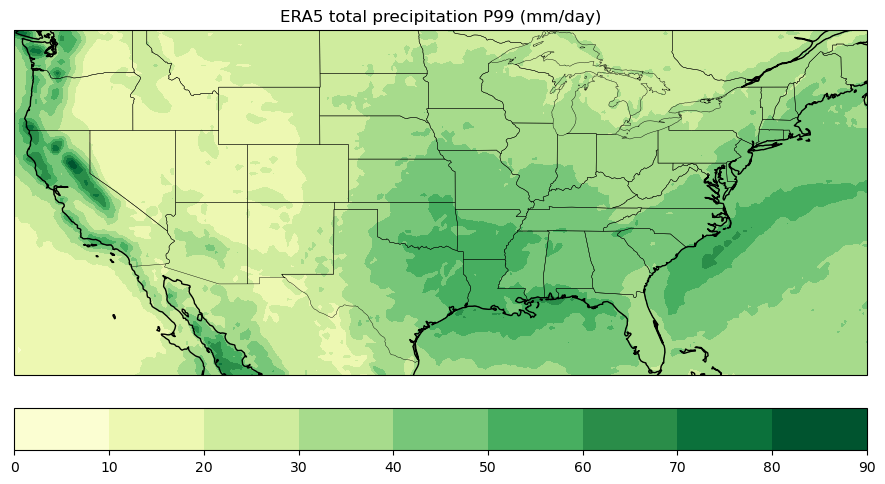

In [33]:
# Make the figure larger
fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
filled_c = ax.contourf(prec_p99.lon, prec_p99.lat, prec_p99, cmap = 'YlGn', transform = ccrs.PlateCarree())

# Add coastlines
ax.coastlines()
ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
ax.set_title('ERA5 total precipitation P99 (mm/day)')

# Add a colorbar for the filled contour.
# and pad argument to set colorbar away from x-axis
fig.colorbar(filled_c , orientation="horizontal", pad = 0.05);
 

 - Map of P99 precipitation: Average Precipitation intensity over 2D object 

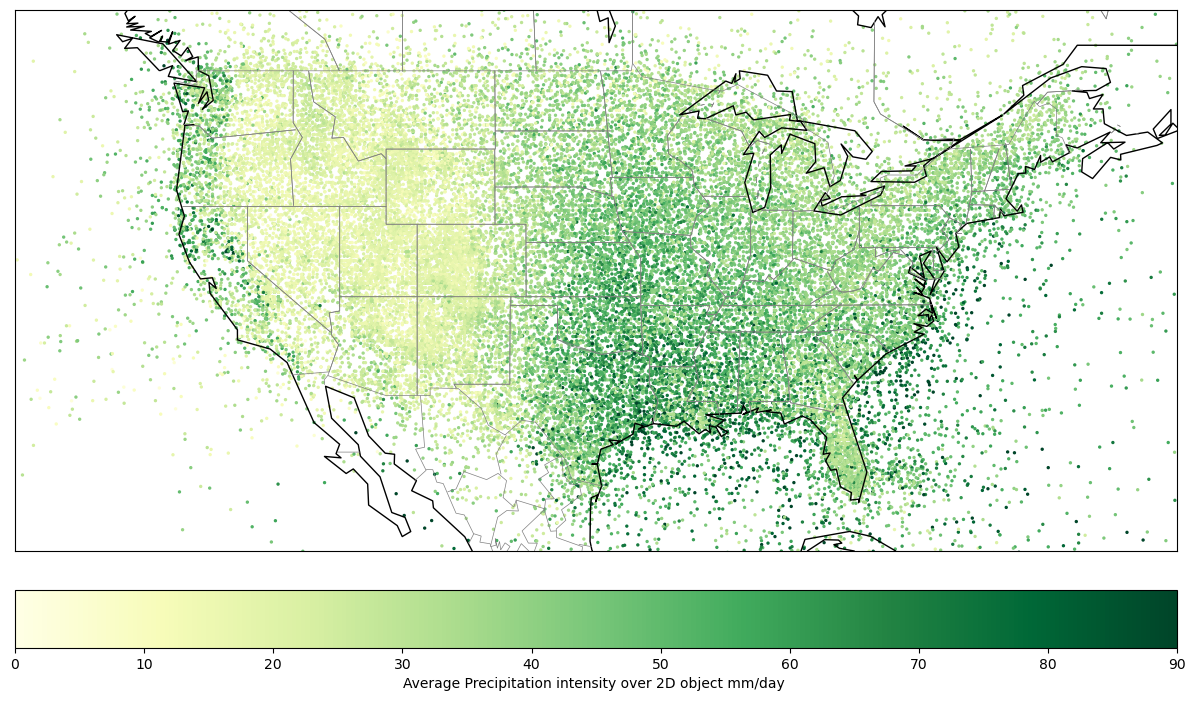

In [36]:
flnm_i = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt'
df = pd.read_csv(flnm_i, sep=" ") 

# setting the size of the map
fig = plt.figure(figsize=(15, 10))


# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = 22, urcrnrlat = 52, llcrnrlon = -135, urcrnrlon = -60, resolution = 'c')

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = df['center_lat'].tolist()
lon = df['center_lon'].tolist()

# plotting the map
m.scatter(lon, lat,  c = df['avg_precip_2d'], latlon = True,cmap='YlGn', s=2, alpha = 1, vmin=0, vmax=90)
#create colorbar 
plt.colorbar(label=r'Average Precipitation intensity over 2D object mm/day ', orientation="horizontal", pad = 0.05);

- Maximum Precipitation intensity over 2D object

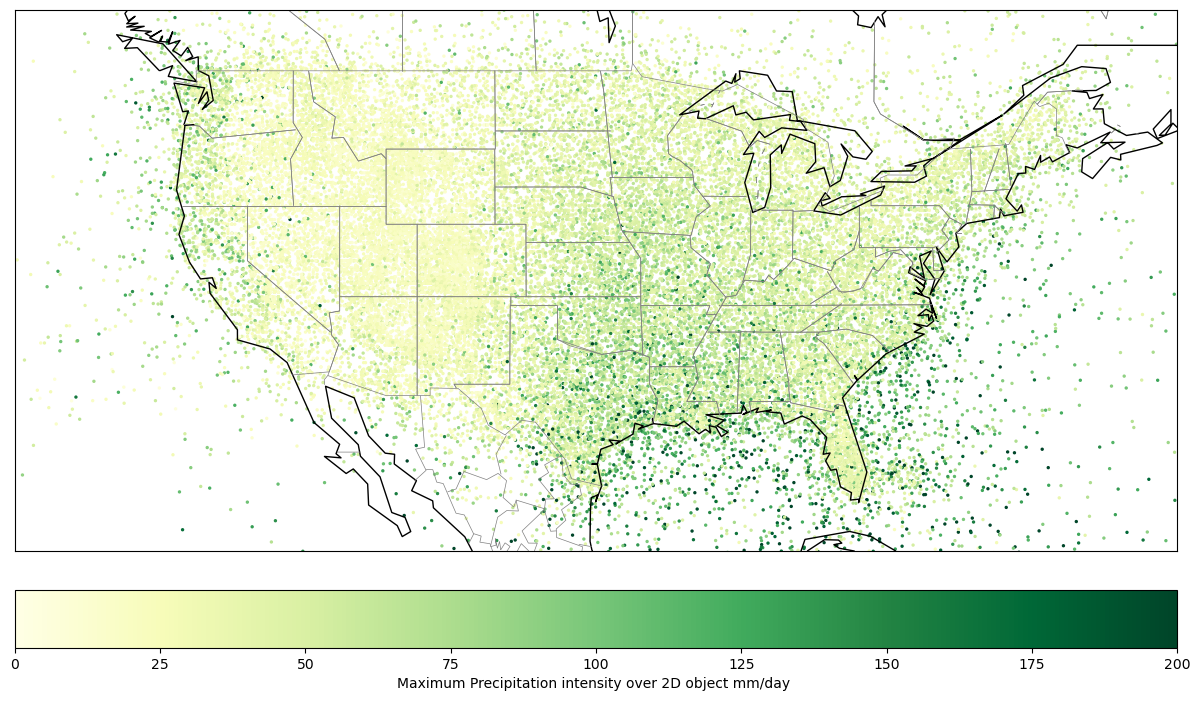

In [38]:
flnm_i = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt'
df = pd.read_csv(flnm_i, sep=" ") 

# setting the size of the map
fig = plt.figure(figsize=(15, 10))

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = 22, urcrnrlat = 52, llcrnrlon = -135, urcrnrlon = -60, resolution = 'c')

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = df['center_lat'].tolist()
lon = df['center_lon'].tolist()

# plotting the map
m.scatter(lon, lat,  c = df['max_precip_2d'], latlon = True,cmap='YlGn', s=2, alpha = 1, vmin=0, vmax=200)
#create colorbar 
plt.colorbar(label=r'Maximum Precipitation intensity over 2D object mm/day ', orientation="horizontal", pad = 0.05);

 - 1b c) Maps of P99 frequency by grid point in winter and summer

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/count_p99_1979-2019_winter.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/count_p99_1979-2019_summer.nc


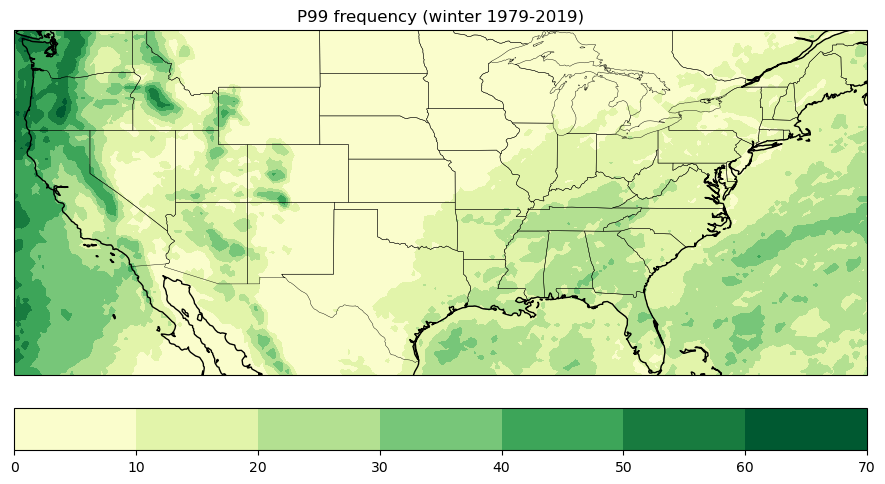

In [45]:
season_1d = ['winter','summer']
n_season = len(season_1d)

for ns in range(n_season):
    flnm = dir_o + 'count_p99_1979-2019_' + season_1d[ns]+  '.nc'
    print(flnm)
    with  xr.open_dataset(flnm) as ds:
        p99_count = ds.p99_count
        
    # Make the figure larger
    fig = plt.figure(figsize=(11,8.5))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())

    # Make a filled contour plot
    filled_c = ax.contourf(p99_count.lon, p99_count.lat, p99_count, cmap = 'YlGn', transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title('P99 frequency (' + season_1d[ns] + ' ' + str(year_s) + '-' + str(year_e) +  ')')

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c , orientation="horizontal", pad = 0.05);
             

 - 1d area for 2D object

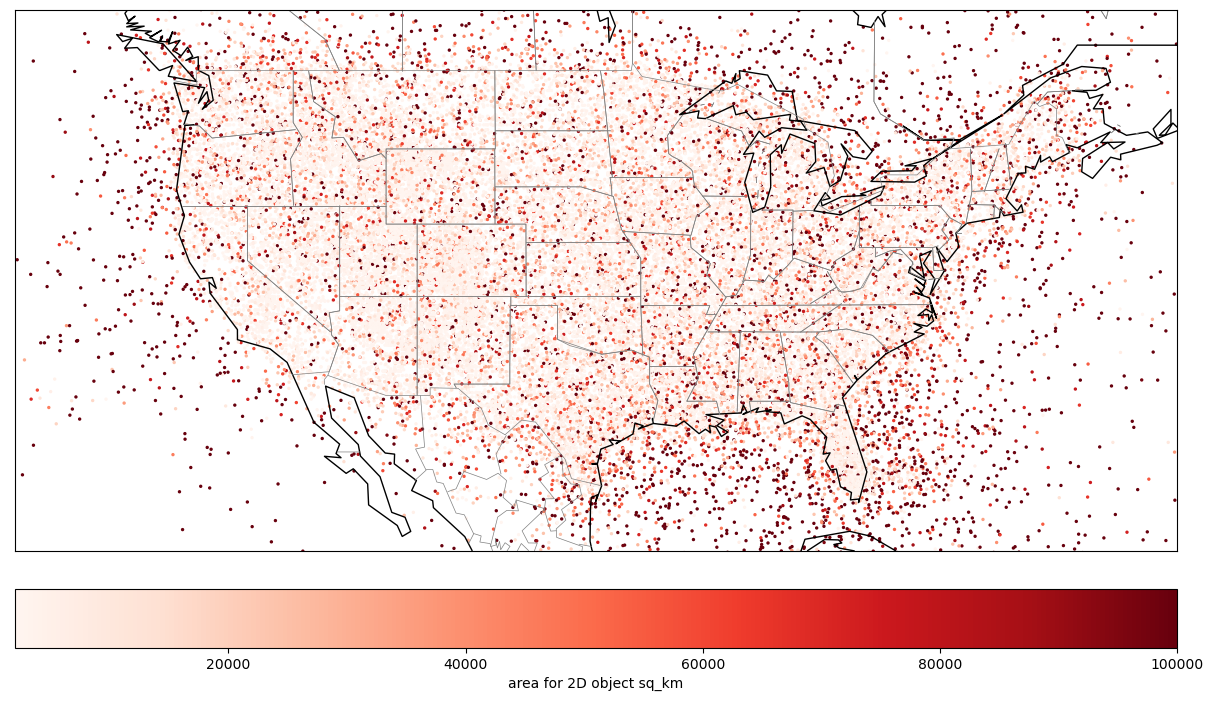

In [39]:
# setting the size of the map
fig = plt.figure(figsize=(15, 10))

# creating the map - setting latitude and longitude
m = Basemap(projection = 'mill', llcrnrlat = 22, urcrnrlat = 52, llcrnrlon = -135, urcrnrlon = -60, resolution = 'c')

# drawing the coastline
m.drawcoastlines()
m.drawcountries(color='gray')
m.drawstates(color='gray')

# creating variable for latitude and longitude to list
lat = df['center_lat'].tolist()
lon = df['center_lon'].tolist()

# plotting the map
m.scatter(lon, lat,  c = df['area'], latlon = True,cmap='Reds', vmin= 2000, vmax= 100000, s=2, alpha = 1)
#create colorbar 
plt.colorbar(label=r'area for 2D object sq_km', orientation="horizontal", pad = 0.05);


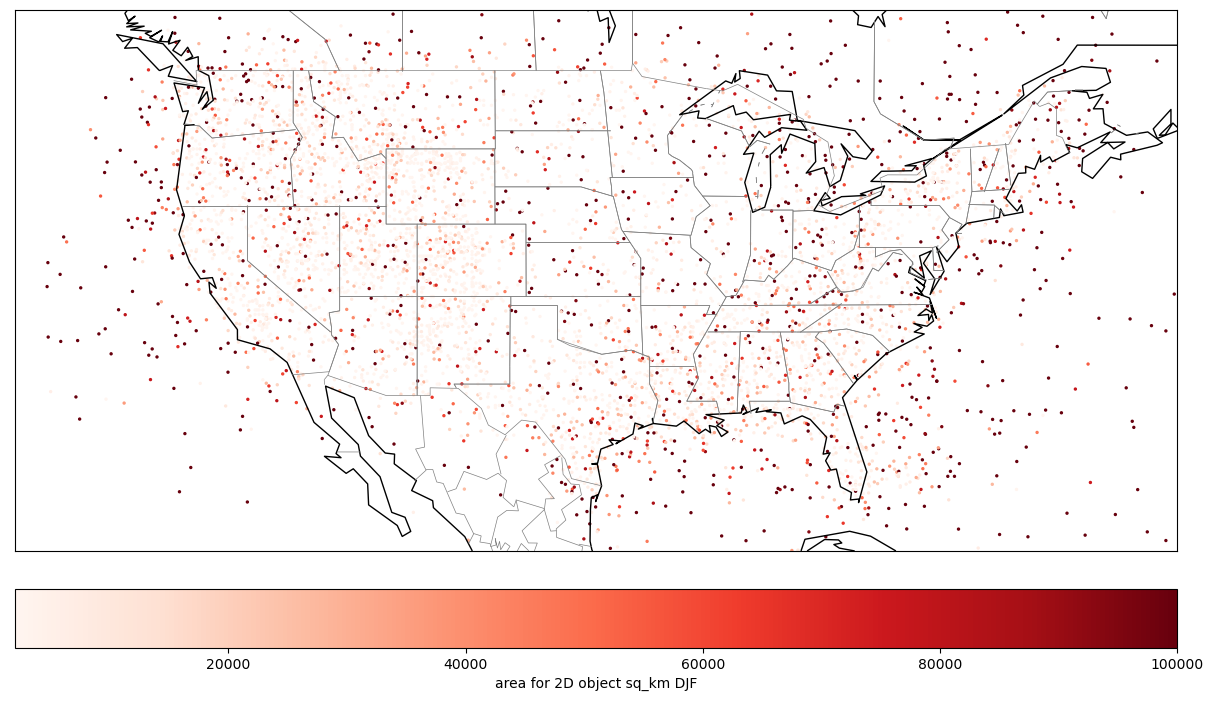

In [40]:
huc2_season = df.groupby(['season']) 
n_season = huc2_season.ngroups 
#print('there are: ', n_season, ' groups')

for name_of_group, contents_of_group in huc2_season:
    name_of_group_s = str(name_of_group).replace("'","").replace(",","").replace("(","").replace(")","")
    # print(name_of_group_s)
    if name_of_group_s == "DJF" or name_of_group_s == "JJA":
        #print('--name_of_group', name_of_group, "-")
        #print('-- contents_of_group', type(contents_of_group))
        fig = plt.figure(figsize=(15, 10))
        
        m = Basemap(projection = 'mill', llcrnrlat = 22, urcrnrlat = 52, llcrnrlon = -135, urcrnrlon = -60, resolution = 'c')

        # drawing the coastline
        m.drawcoastlines()
        m.drawcountries(color='gray')
        m.drawstates(color='gray')
        
        # creating variable for latitude and longitude to list
        lat = contents_of_group['center_lat'].tolist()
        lon = contents_of_group['center_lon'].tolist()
        
        # plotting the map
        m.scatter(lon, lat,  c = contents_of_group['area'], latlon = True,cmap='Reds', vmin= 2000, vmax= 100000, s=2, alpha = 1)
        #create colorbar 
        plt.colorbar(label='area for 2D object sq_km ' + name_of_group_s, orientation="horizontal", pad = 0.05);


#### Danielle Touma's HUC ( it's U.S. river basins instead of HUC)

/glade/scratch/mingge/ipykernel_238948/1745393740.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd_de["center"] = shp_gpd_de["geometry"].centroid


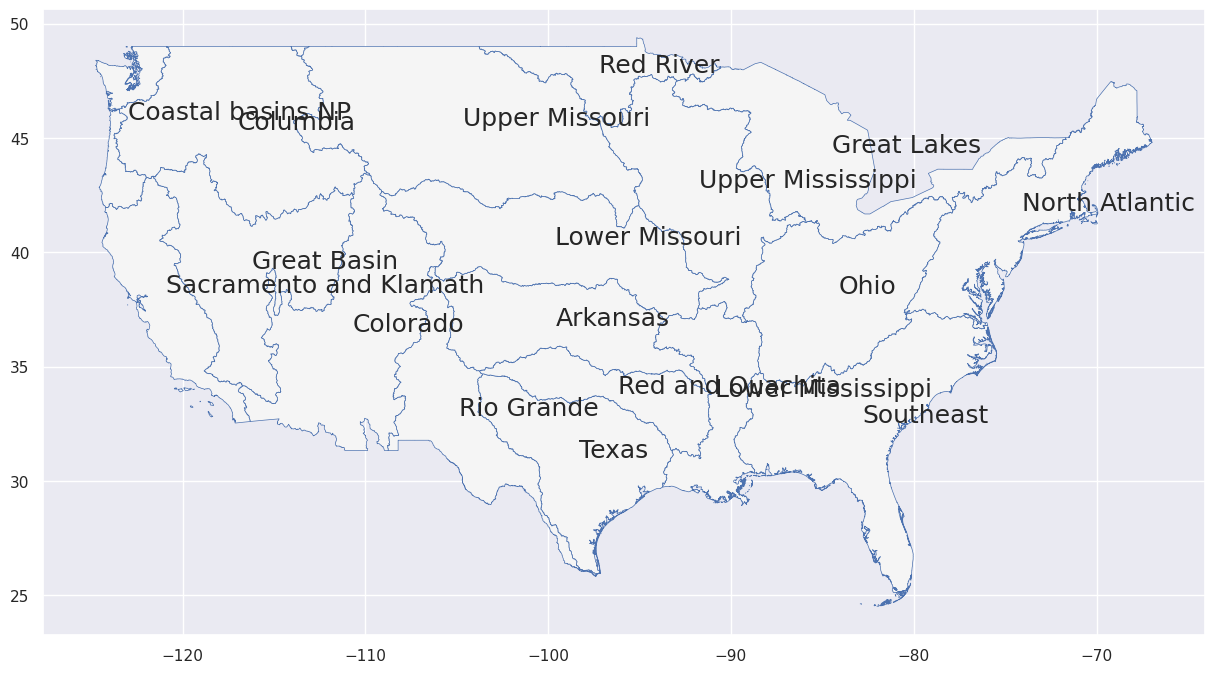

In [43]:
flnm_shp_de = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/US_river_basins/US_river_basins.shp'
shp_gpd_de = gpd.read_file(flnm_shp_de)

shp_gpd_de["center"] = shp_gpd_de["geometry"].centroid
shp_gpd_de_points = shp_gpd_de.copy()
shp_gpd_de_points.set_geometry("center", inplace = True)
ax = shp_gpd_de.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "b", linewidth = 0.5)

texts = []
# labelling districts in GeoPandas
for x, y, label in zip(shp_gpd_de_points.geometry.x, shp_gpd_de_points.geometry.y, shp_gpd_de_points["names"]):
    texts.append(plt.text(x, y, label, fontsize = 18))

#shp_gpd_de.names;
#print(shp_gpd_de)
 

#### HUC2

In [9]:
flnm_shp = '/glade/work/mingge/SHAPEFILES/HUC4/NHDPlusv2_HUC4.shp'
flnm_shp = "/glade/work/mingge/SHAPEFILES/usgs_hucs/HUC02_conus.shp"

shp_gpd = gpd.read_file(flnm_shp)
#shp_gpd.Name

name_huc2 = shp_gpd.Name.tolist()
# using list comprehension + replace()
# Replace substring in list of strings
res = [sub.replace(' Region', '') for sub in name_huc2]
# print result
print("The list after substring replacement : " + str(res))  

#  labelling districts in GeoPandas.
# Here we find the center points, copy our original df to a new df, and then set 
# the geometry column to the newly created center points column 
# (because a GeoPandas df can only have one geometry column)
sns.set_theme()
za = shp_gpd
za["center"] = za["geometry"].centroid
za_points = za.copy()
za_points.set_geometry("center", inplace = True)
ax = za.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "b", linewidth = 0.5)
texts = []

for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["Name"]):
    texts.append(plt.text(x, y, label, fontsize = 18))

The list after substring replacement : ['Tennessee', 'Lower Colorado', 'California', 'South Atlantic-Gulf', 'Upper Mississippi', 'Lower Mississippi', 'Souris-Red-Rainy', 'Missouri', 'Upper Colorado', 'Pacific Northwest', 'Great Lakes', 'New England', 'Ohio', 'Texas-Gulf', 'Arkansas-White-Red', 'Rio Grande', 'Great Basin', 'Mid Atlantic']


/glade/scratch/mingge/ipykernel_238948/3359886309.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  za["center"] = za["geometry"].centroid


#### 2 For each region:
- a) plot probability distributions of 14-day P99 event counts
- b) scatter plots of 14-day P99 event count vs. avg P99 size
- c) scatter plots of 14-day P99 event count vs. avg P99 rainrate


In [44]:
# read Obj file and group it according to HUC
dir_obj = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
flnm_obj = dir_obj + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt'
print(flnm_obj)

df = pd.read_csv(flnm_obj, sep=" ") 
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt


In [45]:
# Split Data into 'HUC2' Groups by .groupby() function. 
# This returns a GroupBy object which is a dictionary
# Then use different methods on this object 
huc2_g = df.groupby(['HUC2']) 

# number of unique groups
# the same as df.HUC2.nunique() 
n_huc2 = huc2_g.ngroups 
print('there are: ', n_huc2, ' groups')

# group size : counts the number of rows in each group
huc2_g.size()

there are:  18  groups


HUC2
Arkansas                1668
CoastalBasinsNP          426
Colorado                3568
Columbia                2880
GreatBasin              2100
GreatLakes              1842
LowerMississippi        1059
LowerMissouri           2167
NorthAtlantic           1214
Ohio                    2107
RedAndOuachita           811
RedRiver                 517
RioGrande               1619
SacramentoAndKlamath     792
Southeast               2955
Texas                   1665
UpperMississippi        1871
UpperMissouri           3265
dtype: int64

In [47]:
huc2_1d = huc2_g.groups.keys() 
name_huc2 = list(huc2_1d)

In [48]:
StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2019, 12, 31, 23)

TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')

n_day = len(TimeDD)

n_year = TimeDD.year.max() - TimeDD.year.min() + 1
year_s = TimeDD.year[0]
year_e = TimeDD.year[-1]

TimeDD

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=14975, freq='D')

- 2a) plot probability distributions of 14-day P99 event counts

In [54]:
%%time
# plotting a histogram
#set seaborn plotting aesthetics as default
sns.set()
n_col = 6
n_row = 3

#define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))

# add extra space between rows
fig.tight_layout(h_pad=4)

# Group By object is a dictionary, iterate through it as with dictionary 
# reference
# https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
# 14-day running sum
window_size = 14
 
n_ActDD = n_day - window_size + 1

ct = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date']]
    arr_1d  = np.zeros((n_ActDD), dtype=int)
    # Loop through the TimeDD array to consider
    # every window of size 14
    i = 0
    while i < n_ActDD:
        window = TimeDD[i : i + window_size]
         
        # select rows between two values
        event_select = event_date[event_date['date'].between(window[0], window[-1])]
        #print(i, window[0], window[-1])
        #print(event_select)
        if not event_select.empty:
            arr_1d[i] = event_select['event_id'].nunique()
        else:
            arr_1d[i] = 0
         
        i += 1
    
    nrow = int(ct/n_col)
    ncol = ct - nrow*n_col 
    # Create the pandas DataFrame with column name is provided explicitly 
    data = {'obj count':  arr_1d,
        'date' : TimeDD[:len(arr_1d)]}
    df = pd.DataFrame(data) 
    sns.histplot(ax=axes[nrow, ncol],data=df["obj count"], stat="density", binwidth=1).set(title=str(name_of_group).replace("'", '').replace(",", '')); #, kde=True)
    ct += 1 
    

CPU times: user 2min 11s, sys: 0 ns, total: 2min 11s
Wall time: 2min 15s


b) scatter plots of 14-day P99 event count vs. avg P99 size

In [56]:
#define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))
fig.tight_layout(h_pad=4)

ng = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date', 'area']]
    
    ct_1d    = np.zeros((n_ActDD), dtype=int)
    area_1d  = np.zeros((n_ActDD), dtype=int)
    
    # Loop through the TimeDD array to consider every window of size 14
    i = 0
    while i < n_ActDD:
        window = TimeDD[i : i + window_size]
         
        # select rows between two values
        event_select = event_date[event_date['date'].between(window[0], window[-1])]

        #print(i, window[0], window[-1])
        
        if not event_select.empty:
            ct_1d[i] = event_select['event_id'].nunique()
            #print(event_select)
            
            # for each unique event - group by event_id 
            event_unique = event_select.groupby(['event_id'])
            ct_id = 0
            for name_of_subgroup, contents_of_subgroup in event_unique:
                area_t = np.average(contents_of_subgroup['area'].to_numpy() )
                area_1d[i] = area_1d[i] + area_t 
                                            
                ct_id = ct_id + 1
            area_1d[i] = area_1d[i]/ct_id
            #print('unique ', ct_1d[i], 'area avg', area_1d[i])
        else:
            ct_1d[i] = 0
         
        i += 1
    
    nrow = int(ng/n_col)
    ncol = ng - nrow*n_col 
    
    axes[nrow,ncol].scatter(ct_1d, area_1d, c ="blue")
    axes[nrow,ncol].set_title(str(name_of_group).replace("'", '').replace(",", ''))
    axes[nrow,ncol].set_xlim(0.5, max(ct_1d) + 1)
    axes[nrow,ncol].set_xlabel("count")
    axes[nrow,ncol].set_ylabel("area")
    ng += 1

 - 2.c) scatter plots of 14-day P99 event count vs. avg P99 rainrate

In [58]:
%%time
# define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))
fig.tight_layout(h_pad=4)

ng = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date', 'avg_precip_2d']]
    
    ct_1d    = np.zeros((n_ActDD), dtype=int)
    area_1d  = np.zeros((n_ActDD), dtype=int)
    
    # Loop through the TimeDD array to consider every window of size 14
    i = 0
    while i < n_ActDD:
        window = TimeDD[i : i + window_size]
         
        # select rows between two values
        event_select = event_date[event_date['date'].between(window[0], window[-1])]

        #print(i, window[0], window[-1])
        
        if not event_select.empty:
            ct_1d[i] = event_select['event_id'].nunique()
            #print(event_select)
            
            # for each unique event - group by event_id 
            event_unique = event_select.groupby(['event_id'])
            ct_id = 0
            for name_of_subgroup, contents_of_subgroup in event_unique:
                area_t = np.average(contents_of_subgroup['avg_precip_2d'].to_numpy() )
                area_1d[i] = area_1d[i] + area_t 
                                            
                ct_id = ct_id + 1
            area_1d[i] = area_1d[i]/ct_id
            #print('unique ', ct_1d[i], 'area avg', area_1d[i])
        else:
            ct_1d[i] = 0
         
        i += 1
        
    nrow = int(ng/n_col)
    ncol = ng - nrow*n_col 
    axes[nrow,ncol].scatter(ct_1d, area_1d, c ="blue")
    axes[nrow,ncol].set_title(str(name_of_group).replace("'", '').replace(",", ''))
    axes[nrow,ncol].set_xlim(0.5, max(ct_1d) + 1)
    axes[nrow,ncol].set_xlabel("count")
    axes[nrow,ncol].set_ylabel("avg_precip_2d")
    ng += 1

CPU times: user 3min 40s, sys: 202 ms, total: 3min 40s
Wall time: 3min 45s


#### section 3
map plot of 14-day P99 event count for each region

In [62]:
%%time
# read Obj file and group it according to HUC
dir_obj = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
flnm_obj = dir_obj + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt'
print(flnm_obj)

df = pd.read_csv(flnm_obj, sep=" ")
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
huc2_g = df.groupby(['HUC2']) 

StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2019, 12, 31, 23)

TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')

n_day = len(TimeDD)

# 14-day running sum
window_size = 14
 
n_ActDD = n_day - window_size + 1
n_huc = len(huc2_g)
count_1d  = np.zeros((n_huc), dtype=int)

ng = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date']]
    
    # Loop through the TimeDD array to consider
    # every window of size 14
    i = 0
    while i < n_ActDD:
        window = TimeDD[i : i + window_size]
         
        # select rows between two values
        event_select = event_date[event_date['date'].between(window[0], window[-1])]
        #print(i, window[0], window[-1])
        #print(event_select)
        if not event_select.empty:
            count_1d[ng] = count_1d[ng] + event_select['event_id'].nunique()
         
        i += 1
    #print(count_1d[ng], name_of_group, ng)
    ng = ng + 1

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2019_US.txt
CPU times: user 2min 5s, sys: 30.8 ms, total: 2min 6s
Wall time: 2min 9s


In [63]:
flnm_shp_de = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/US_river_basins/US_river_basins.shp'
shp_gpd_de = gpd.read_file(flnm_shp_de)

# reorder count according to shapefile order
# series to list
name_shp = shp_gpd_de.names.tolist() 

# Replace substring in list of strings
name_shp = [sub.replace(' ', '').lower() for sub in name_shp]

name_obj = (list(huc2_g.groups.keys()))
name_obj = [sub.lower() for sub in name_obj]

new_count_1d = count_1d.copy()

for ns in range(n_huc):
    # get the index of name_shp[ns]
    index = name_obj.index(name_shp[ns])
    new_count_1d[ns] = count_1d[index]
    print(new_count_1d[ns], name_shp[ns], index, count_1d[index])

45155 colorado 2 45155
10371 sacramentoandklamath 13 10371
37591 columbia 3 37591
7070 redriver 11 7070
25087 greatlakes 5 25087
38322 southeast 14 38322
21049 texas 15 21049
20807 riogrande 12 20807
27407 greatbasin 4 27407
10719 redandouachita 10 10719
21837 arkansas 0 21837
27907 ohio 9 27907
5821 coastalbasinsnp 1 5821
16353 northatlantic 8 16353
42774 uppermissouri 17 42774
28356 lowermissouri 7 28356
14196 lowermississippi 6 14196
25095 uppermississippi 16 25095


/glade/scratch/mingge/ipykernel_80825/616107821.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd_de['lon_centroid'] = shp_gpd_de.centroid.x
/glade/scratch/mingge/ipykernel_80825/616107821.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd_de['lat_centroid'] = shp_gpd_de.centroid.y


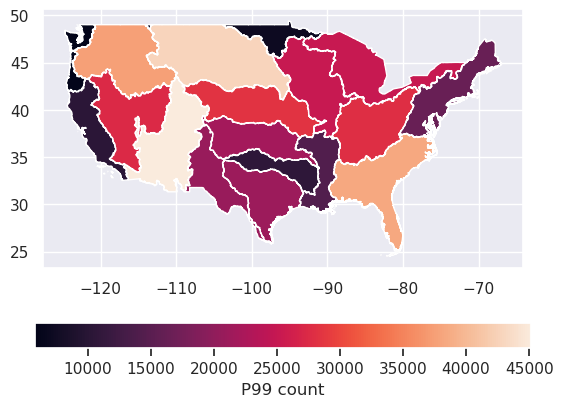

In [64]:
crs={'init':'epsg:4326'}

shp_gpd_de = shp_gpd_de.to_crs('EPSG:4326')
shp_gpd_de['lon_centroid'] = shp_gpd_de.centroid.x  
shp_gpd_de['lat_centroid'] = shp_gpd_de.centroid.y
shp_gpd_de["p99_count"] = new_count_1d

shp_gpd_de.plot(column="p99_count", legend=True,
               legend_kwds={"label": "P99 count", "orientation": "horizontal"},);

#### The Fitter Package: Quick Distribution Identification
The fitter package in Python provides a simple and convenient way to fit various probability distributions to your data and compare their goodness of fit.<br>
https://medium.com/@patil.manojkumar/probability-distributions-in-python-a-practical-guide-for-beginners-3164f198a398